In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Для Jupyter
%matplotlib inline

Размер матрицы: (531, 413)
Тип данных: float64
Диапазон значений: [0.0, 255.0]
Пример значений:
[[255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]]


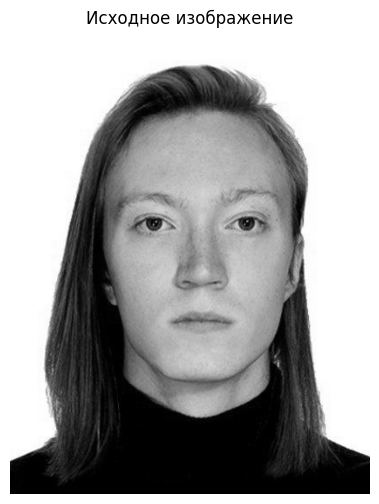

In [9]:
# === ЗАГРУЗКА И АНАЛИЗ ИЗОБРАЖЕНИЯ ===

# Загрузка изображения и преобразование в ч/б
image = Image.open('1.jpg').convert('L')
image_array = np.array(image, dtype=float)

print(f"Размер матрицы: {image_array.shape}")
print(f"Тип данных: {image_array.dtype}")
print(f"Диапазон значений: [{image_array.min()}, {image_array.max()}]")
print(f"Пример значений:\n{image_array[:3, :3]}")

# Показываем исходное изображение
plt.figure(figsize=(8, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()


Всего FFT коэффициентов: 219303


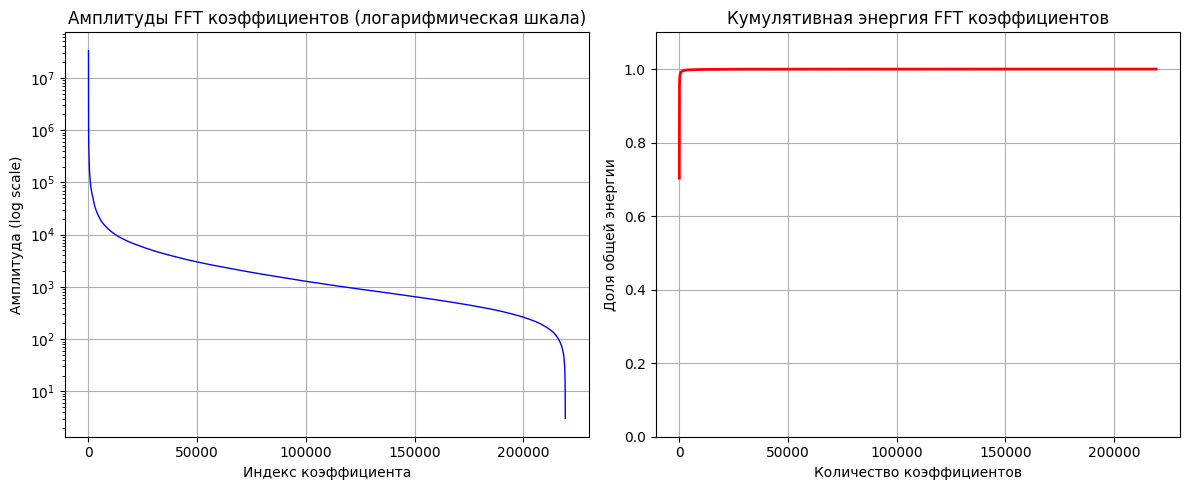

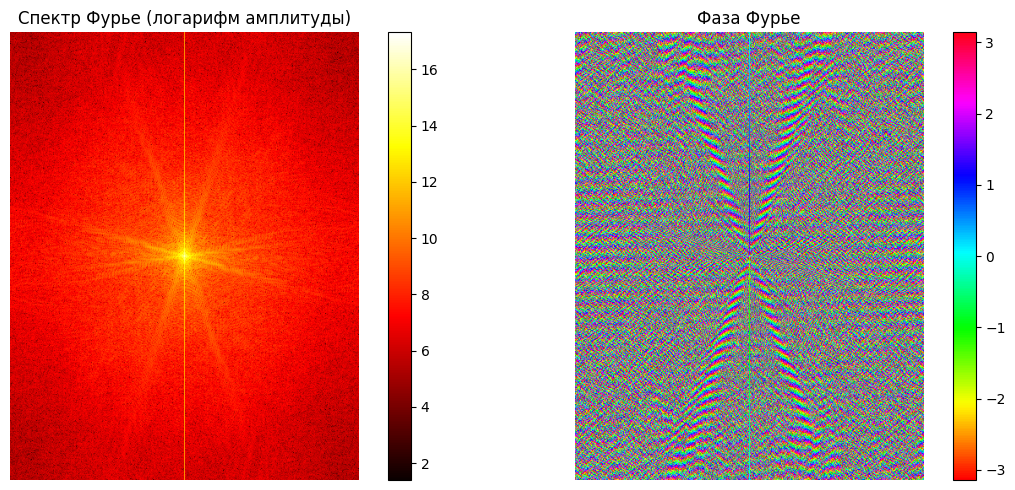

In [10]:
# === FFT ПРЕОБРАЗОВАНИЕ И АНАЛИЗ ===

# Выполняем 2D FFT
fft_transform = np.fft.fft2(image_array)
fft_shifted = np.fft.fftshift(fft_transform)  # Сдвигаем нулевую частоту в центр

# Вычисляем амплитуды (модули) коэффициентов
magnitudes = np.abs(fft_transform)
magnitudes_sorted = np.sort(magnitudes.ravel())[::-1]  # Сортируем по убыванию

# Общее количество коэффициентов
total_coeffs = len(magnitudes_sorted)
print(f"\nВсего FFT коэффициентов: {total_coeffs}")

# Вычисляем кумулятивную энергию
cumulative_energy = np.cumsum(magnitudes_sorted**2) / np.sum(magnitudes_sorted**2)

# График амплитуд коэффициентов и кумулятивной энергии
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(magnitudes_sorted, 'b-', linewidth=1)
plt.title('Амплитуды FFT коэффициентов (логарифмическая шкала)')
plt.xlabel('Индекс коэффициента')
plt.ylabel('Амплитуда (log scale)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_energy, 'r-', linewidth=2)
plt.title('Кумулятивная энергия FFT коэффициентов')
plt.xlabel('Количество коэффициентов')
plt.ylabel('Доля общей энергии')
plt.grid(True)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Визуализация спектра Фурье
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
plt.imshow(magnitude_spectrum, cmap='hot')
plt.title('Спектр Фурье (логарифм амплитуды)')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(fft_shifted), cmap='hsv')
plt.title('Фаза Фурье')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [12]:
# === ФУНКЦИИ ДЛЯ FFT СЖАТИЯ ===

def compress_fft(fft_coeffs, keep_ratio):
    """
    Сжатие FFT коэффициентов - сохранение только максимальных по амплитуде коэффициентов
    """
    # Получаем амплитуды коэффициентов
    magnitudes = np.abs(fft_coeffs)
    
    # Вычисляем порог для сохранения указанного процента коэффициентов
    total_coeffs = fft_coeffs.size
    keep_count = int(total_coeffs * keep_ratio)
    
    # Находим пороговое значение
    threshold = np.partition(magnitudes.ravel(), -keep_count)[-keep_count]
    
    # Создаем маску для коэффициентов выше порога
    mask = magnitudes >= threshold
    
    # Применяем маску - обнуляем малые коэффициенты
    compressed_fft = fft_coeffs * mask
    
    return compressed_fft, mask, keep_count

def reconstruct_from_fft(compressed_fft):
    """Восстановление изображения из сжатых FFT коэффициентов"""
    # Обратное FFT преобразование
    reconstructed = np.fft.ifft2(compressed_fft).real
    
    # Ограничиваем значения в диапазоне 0-255
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed.astype(np.uint8)


РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ FFT
Уровень    Коэфф.   % энергии    Ошибка Фробениуса   
------------------------------------------------------------
10%        21930    99.95     % 1884.82             
5%         10965    99.90     % 2626.69             
1%         2193     99.64     % 4941.47             
0.2%       438      98.75     % 9124.71             


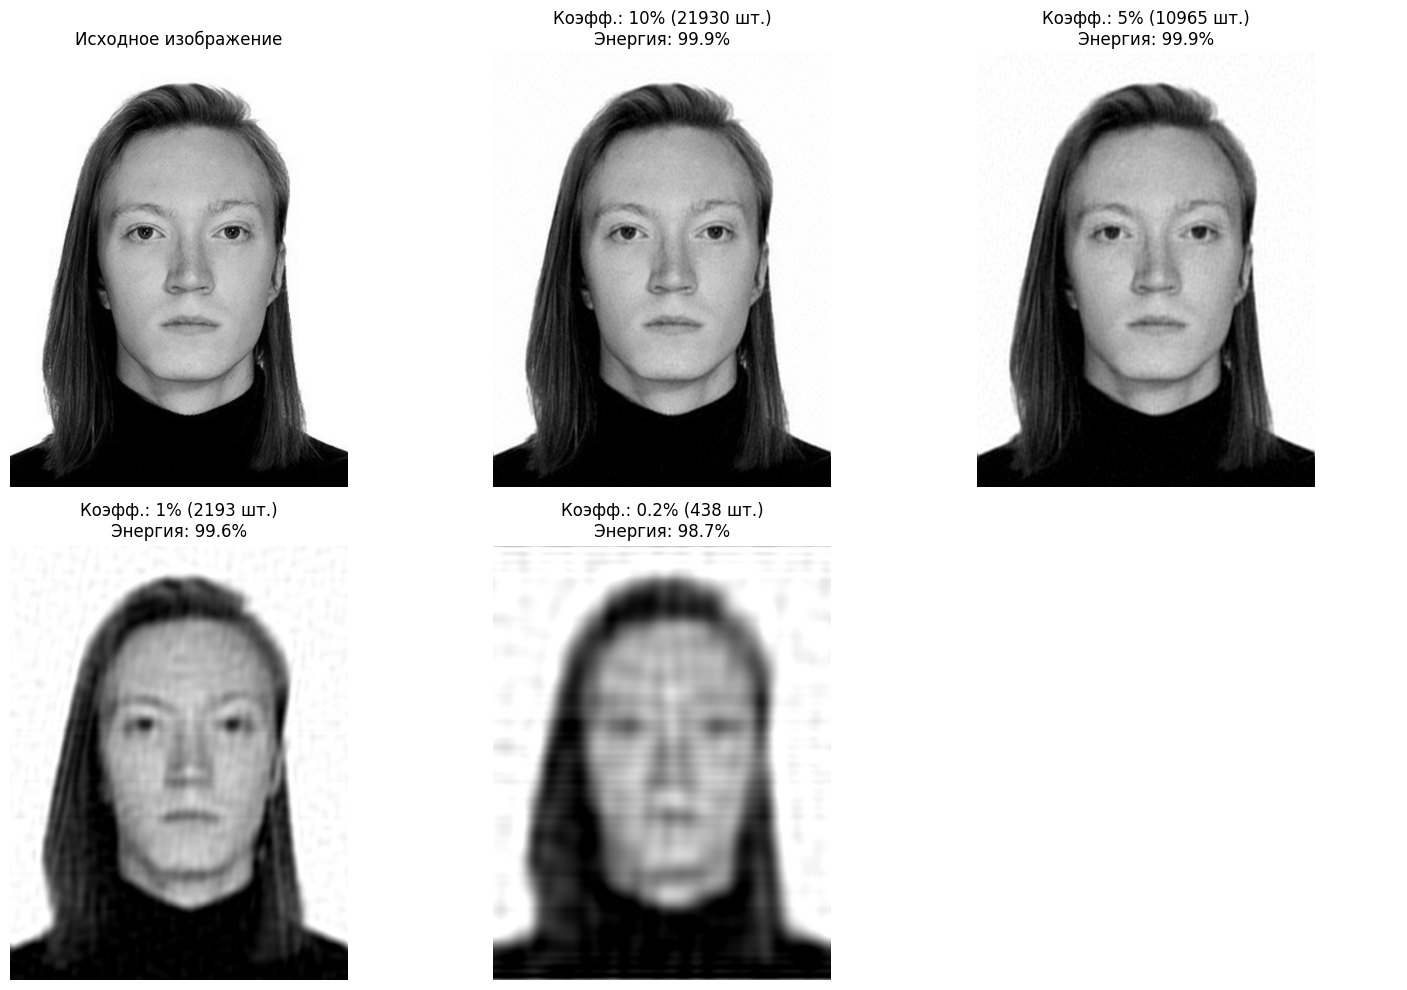

In [13]:
# === ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЖАТИЯ ===

# Проценты для усечения
compression_ratios = [0.10, 0.05, 0.01, 0.002]
ratios_names = ['10%', '5%', '1%', '0.2%']

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ FFT")
print("="*80)
print(f"{'Уровень':<10} {'Коэфф.':<8} {'% энергии':<12} {'Ошибка Фробениуса':<20}")
print("-" * 60)

# Визуализация результатов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Исходное изображение
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Восстановленные изображения для разных уровней сжатия
for i, (ratio, name) in enumerate(zip(compression_ratios, ratios_names)):
    # Сжимаем FFT коэффициенты
    compressed_fft, mask, kept_coeffs = compress_fft(fft_transform, ratio)
    
    # Восстанавливаем изображение
    reconstructed = reconstruct_from_fft(compressed_fft)
    
    # Вычисляем процент энергии
    total_energy = np.sum(magnitudes_sorted**2)
    kept_energy = np.sum((np.abs(compressed_fft))**2)
    energy_percentage = (kept_energy / total_energy) * 100
    
    # Вычисляем норму Фробениуса ошибки
    error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
    
    print(f"{name:<10} {kept_coeffs:<8} {energy_percentage:<10.2f}% {error_norm:<20.2f}")
    
    # Визуализируем результат
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f'Коэфф.: {name} ({kept_coeffs} шт.)\nЭнергия: {energy_percentage:.1f}%')
    axes[i+1].axis('off')

# Скрываем последний subplot если он не используется
if len(compression_ratios) + 1 < len(axes):
    for j in range(len(compression_ratios) + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

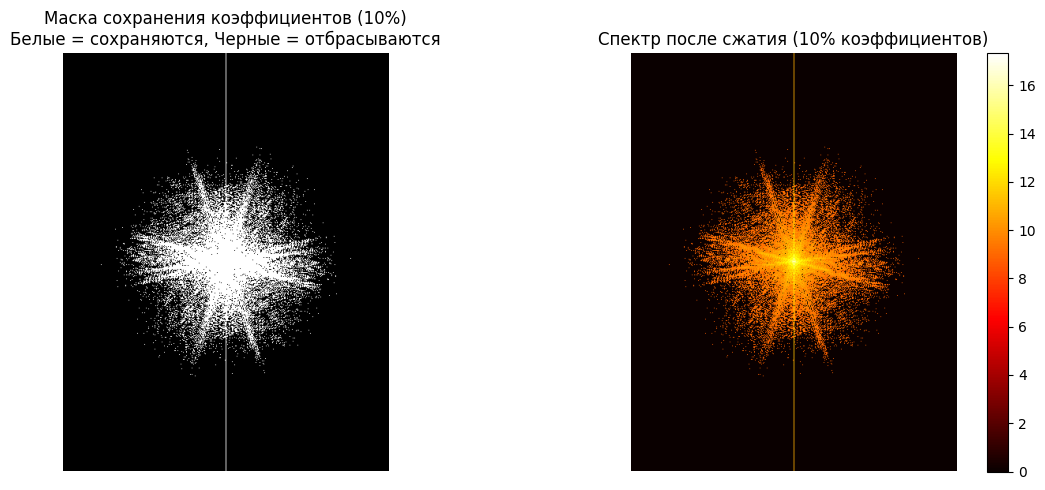

In [14]:
# === ВИЗУАЛИЗАЦИЯ МАСКИ СЖАТИЯ ===

# Покажем маску сжатия для уровня 10%
compressed_fft_10, mask_10, kept_10 = compress_fft(fft_transform, 0.10)
mask_shifted = np.fft.fftshift(mask_10.astype(float))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_shifted, cmap='gray')
plt.title('Маска сохранения коэффициентов (10%)\nБелые = сохраняются, Черные = отбрасываются')
plt.axis('off')

plt.subplot(1, 2, 2)
compressed_shifted = np.fft.fftshift(compressed_fft_10)
magnitude_compressed = np.log(1 + np.abs(compressed_shifted))
plt.imshow(magnitude_compressed, cmap='hot')
plt.title('Спектр после сжатия (10% коэффициентов)')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [15]:
# === АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ ===

print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("="*80)
print(f"Размер исходной матрицы: {image_array.shape}")
print(f"Общее количество элементов: {image_array.size}")
print(f"Размер FFT матрицы: {fft_transform.shape}")

# Экономия памяти для разных уровней сжатия
print("\nЭКОНОМИЯ ПАМЯТИ:")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходный размер':<18} {'Сжатый размер':<16} {'Коэф. сжатия':<12}")
print("-" * 70)

m, n = image_array.shape
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(fft_transform.size * ratio)
    
    # Исходный размер (в элементах) - храним всю матрицу комплексных чисел
    # Каждый комплексный число = 2 float (действительная и мнимая части)
    original_size = m * n * 2  # комплексные числа
    
    # Размер сжатого представления: храним только выбранные коэффициенты
    # Для каждого сохраняемого коэффициента: значение (комплексное) + позиция (2 int)
    compressed_size = kept_coeffs * 2 + kept_coeffs * 2  # значения + позиции
    
    compression_ratio = original_size / compressed_size
    
    print(f"{name:<10} {kept_coeffs:<8} {original_size:<18} {compressed_size:<16} {compression_ratio:<10.2f}x")

# Альтернативный расчет (просто по количеству коэффициентов)
print("\nАЛЬТЕРНАТИВНЫЙ РАСЧЕТ (только коэффициенты):")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходные':<12} {'Сохраненные':<12} {'Коэф. сжатия':<12}")
print("-" * 60)

total_coeffs = fft_transform.size
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(total_coeffs * ratio)
    compression_simple = total_coeffs / kept_coeffs
    
    print(f"{name:<10} {kept_coeffs:<8} {total_coeffs:<12} {kept_coeffs:<12} {compression_simple:<10.2f}x")


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Размер исходной матрицы: (531, 413)
Общее количество элементов: 219303
Размер FFT матрицы: (531, 413)

ЭКОНОМИЯ ПАМЯТИ:
Уровень    Коэфф.   Исходный размер    Сжатый размер    Коэф. сжатия
----------------------------------------------------------------------
10%        21930    438606             87720            5.00      x
5%         10965    438606             43860            10.00     x
1%         2193     438606             8772             50.00     x
0.2%       438      438606             1752             250.35    x

АЛЬТЕРНАТИВНЫЙ РАСЧЕТ (только коэффициенты):
Уровень    Коэфф.   Исходные     Сохраненные  Коэф. сжатия
------------------------------------------------------------
10%        21930    219303       21930        10.00     x
5%         10965    219303       10965        20.00     x
1%         2193     219303       2193         100.00    x
0.2%       438      219303       438          500.69    x


In [16]:
# === СРАВНЕНИЕ С SVD (ОПЦИОНАЛЬНО) ===

def compare_methods():
    """Сравнение эффективности SVD и FFT сжатия"""
    
    print("\n" + "="*80)
    print("СРАВНЕНИЕ МЕТОДОВ SVD И FFT")
    print("="*80)
    
    # Выполним SVD для сравнения
    U, S, VT = np.linalg.svd(image_array, full_matrices=False)
    total_singular_values = len(S)
    
    print(f"{'Метод':<10} {'Уровень':<10} {'r/коэфф.':<10} {'% энергии':<12} {'Ошибка':<15}")
    print("-" * 70)
    
    # Сравниваем для 10% и 1%
    comparison_ratios = [0.10, 0.01]
    
    for ratio in comparison_ratios:
        # FFT сжатие
        compressed_fft, mask, kept_coeffs = compress_fft(fft_transform, ratio)
        reconstructed_fft = reconstruct_from_fft(compressed_fft)
        error_fft = np.linalg.norm(image_array - reconstructed_fft, 'fro')
        
        # Вычисляем энергию для FFT
        magnitudes = np.abs(fft_transform)
        total_energy_fft = np.sum(magnitudes**2)
        kept_energy_fft = np.sum((np.abs(compressed_fft))**2)
        energy_fft = (kept_energy_fft / total_energy_fft) * 100
        
        # SVD сжатие
        r = max(1, int(total_singular_values * ratio))
        reconstructed_svd = U[:, :r] @ np.diag(S[:r]) @ VT[:r, :]
        reconstructed_svd = np.clip(reconstructed_svd, 0, 255).astype(np.uint8)
        error_svd = np.linalg.norm(image_array - reconstructed_svd, 'fro')
        energy_svd = (np.sum(S[:r]) / np.sum(S)) * 100
        
        print(f"{'FFT':<10} {ratio*100:<9.1f}% {kept_coeffs:<10} {energy_fft:<10.2f}% {error_fft:<15.2f}")
        print(f"{'SVD':<10} {ratio*100:<9.1f}% {r:<10} {energy_svd:<10.2f}% {error_svd:<15.2f}")
        print("-" * 70)

# Запуск сравнения
compare_methods()


СРАВНЕНИЕ МЕТОДОВ SVD И FFT
Метод      Уровень    r/коэфф.   % энергии    Ошибка         
----------------------------------------------------------------------
FFT        10.0     % 21930      99.95     % 1884.82        
SVD        10.0     % 41         84.73     % 2687.06        
----------------------------------------------------------------------
FFT        1.0      % 2193       99.64     % 4941.47        
SVD        1.0      % 4          57.35     % 12287.37       
----------------------------------------------------------------------
